# Algorithm 1.2

Define some spatio-temporal data

In [201]:
import numpy as np

In [202]:
def sech(x):
    return 1/np.cosh(x)

In [436]:
xi = np.linspace(-10,10,400)
t = np.linspace(0,4*np.pi,200)
dt = t[1] - t[0]
Xgrid, T = np.meshgrid(xi, t)

In [452]:
# Create two spatio-temporal patterns
f1 = sech(Xgrid+3) * (1*np.exp(1j*2.3*T))
f2 = (sech(Xgrid)*np.tanh(Xgrid))*(2*np.exp(1j*2.8*T))

# Combine signals and make data matrix
f = f1 + f2
X = f.T

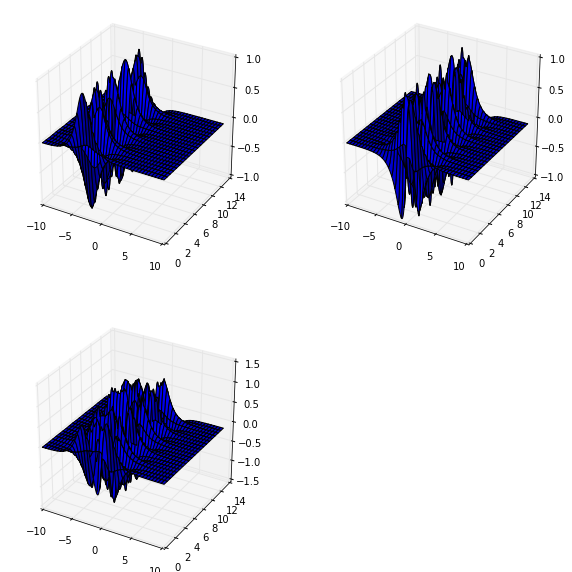

In [453]:
# Visualize f1, f2, and f
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1, projection='3d')
ax1.plot_surface(Xgrid, T, np.real(f1))

ax2 = fig.add_subplot(2,2,2, projection='3d')
ax2.plot_surface(Xgrid, T, np.real(f2))

ax3 = fig.add_subplot(2,2,3, projection='3d')
ax3.plot_surface(Xgrid, T, np.real(f))

# Algorithm 1.3

The DMD algorithm

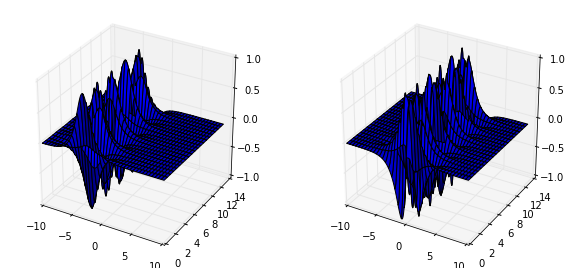

In [432]:
# get two views of the data matrix offset by one time step
X1 = np.matrix(X[:, 0:-2])
X2 = np.matrix(X[:, 1:-1])

In [454]:
# Run SVD on the data view of X1
U,s,Vh = np.linalg.svd(X1)
V = Vh.conj().T
S = np.matrix(np.diag(s))

r = 2
Ur = U[:, 0:r]
Sr = S[0:r, 0:r]
Vr = V[:, 0:r]

## Calculate Atilde

python and numpy do not offer the fancy '/' command as MatLab does.
Instead we solve for Atilde using one of the following approaches.

In [455]:
# Approach 1: works because Sr is square
Atilde = Ur.conj().T*X2*Vr*np.linalg.inv(Sr)
print Atilde

[[ 0.98598568+0.16620242j  0.00345023-0.02133822j]
 [ 0.00159259-0.00975222j  0.98789482+0.15442036j]]


In [456]:
# Approach 2: more general, use least squares to solve aT xT = bT, where:
#   xT = Atilde
#   aT = Sr
#   bT = Ur.conj().T*X2*Vr
__b = Ur.conj().T*X2*Vr
__a = Sr
__r = np.linalg.lstsq(__a.T, __b.T)
__x = __r[0].T
Atilde = __x
print Atilde

[[ 0.98598568+0.16620242j  0.00345023-0.02133822j]
 [ 0.00159259-0.00975222j  0.98789482+0.15442036j]]


## Compute DMD Spectra

Note that the frequency component (the imaginary values) exactly match those used to generate the data

In [458]:
lamb, W = np.linalg.eig(Atilde)
omega = np.log(lamb)/dt
print omega

[ -1.00430675e-15+2.8j  -3.78205593e-15+2.3j]


## Compute DMD solution

Note that the MatLab command: b = Phi\x1

is equivalent to the numpy command: linalg.lstsq(Phi,x1) (if Phi is not square, which it isn't)

In [463]:
# Solve for Phi. Again, the inverse method works because Sr is square.
Phi = X2*Vr*np.linalg.inv(Sr)*W
print Phi.shape

(400, 2)


In [464]:
x1 = np.matrix(X[:,0]).T
b, resid, rank, s = np.linalg.lstsq(Phi, x1)

In [467]:
time_dynamics = None
for i in range(X1.shape[1]):
    v = np.array(b)[:,0]*np.exp( np.array(omega)*(i+1)*dt)
    if time_dynamics is None:
        time_dynamics = v
    else:
        time_dynamics = np.vstack((time_dynamics, v))
X_dmd = np.dot( np.array(Phi), time_dynamics.T)

## Plot the results

Compare the actual time series data (solid blue) with the DMD estimates (dotted red) at N equally spaced spatial points. 

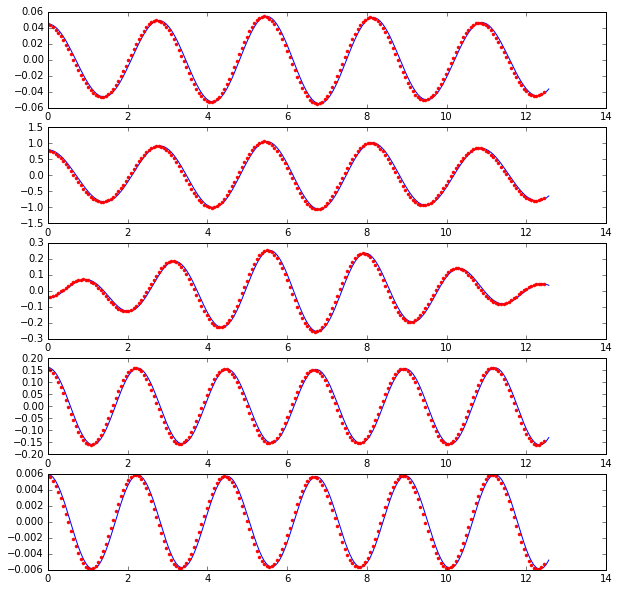

In [473]:
fig = plt.figure(figsize=(10,10))
N = 5
for i in range(N):
    ax = fig.add_subplot(N,1,1+i)
    row = int(X.shape[0]/float(N+1))*(i+1)
    ax.plot(t, X[row,:], color='blue')
    ax.plot(t[0:-2], X_dmd[row,:], '.', color='red')